In [320]:
'''
Figure 2. Results for peaks as a function of osset from most previus task cueu

Validated run cue points:
8.05
23.163
38.291
53.431
68.545
98.666
113.793
128.92
159.041
174.168

Analysis of interest: L2_new ~ t_offset
'''


'\nFigure 2. Results for peaks as a function of osset from most previus task cueu\n\nValidated run cue points:\n8.05\n23.163\n38.291\n53.431\n68.545\n98.666\n113.793\n128.92\n159.041\n174.168\n\nAnalysis of interest: L2_new ~ t_offset\n\n'

In [321]:
from preprocessing import get_bold_task, task_events

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Helvetica"

from time import time

from scipy.signal import find_peaks
from scipy.stats import chisquare

os.chdir('/Users/spencerbrown/PycharmProjects/Neuro')

cmap = [
    '#003f5c',
    '#2f4b7c',
    '#665191',
    '#a05195',
    '#d45087',
    '#f95d6a',
    '#ff7c43',
    '#ffa600']

In [322]:
atlas = 'Schaefer2018_fslr32k'
task = 'MOTOR'
# parcels = [200, 300, 400]
parcels = 300
dims = 2 # Number of homology dimensions to compute.
frames = 284
TR = 0.72
acquisition = frames * TR

bw = 15 # std of gaussian kernel.

subjects = pd.read_excel('SubjectList.xlsx')
subjects = subjects.Subject[subjects.Task == True]
subjects = np.array(subjects)

In [323]:
cues = np.arange(11, 263+21, 21) # In frame space.
cues_frame = cues[1:-1] # dropping first and last.
cues_time = cues_frame * TR # converted to a time space. 
cues_offset = cues_frame - cues_frame[0]

t_frames = np.arange(2*bw, frames - 2*bw + 1)
t_time = t_frames * TR

start_drop = np.ceil(cues_frame[0] - t_frames[0]).astype(int)
acquisition_valid = (len(cues_frame) - 1) * 21

t_offset = np.arange(acquisition_valid)

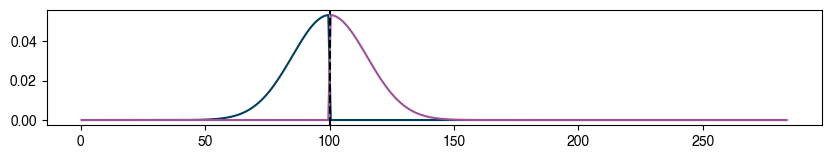

In [324]:
#t = np.linspace(0, acquisition, frames)
def kern_a(std, offset):
    t = np.arange(frames) + 0.5 # offsets to look at center of frame
    sig2 = 2 * std * std
    w = np.exp(-1 * ((t - offset) ** 2) / sig2)
    w[int(offset):] = 0
    scale = 2 / (std*np.sqrt(2*np.pi))
    w = w * scale
    return w

def kern_b(std, offset):
    t = np.arange(frames) + 0.5
    sig2 = 2 * std * std
    w = np.exp(-1 * ((t - offset) ** 2) / sig2)
    w[:int(offset)] = 0
    scale = 2 / (std*np.sqrt(2*np.pi))
    w = w * scale
    return w

t = np.arange(frames) + 0.5
a = kern_a(15, 100)
b = kern_b(15, 100)
plt.figure(figsize=(10, 1.5))
plt.plot(t, a, c=cmap[0])
plt.plot(t, b, c=cmap[3])
plt.axvline(100, color='k', linestyle='--')
plt.show()

In [325]:
def get_L2(sub, run):
    t0 = time()

    bold = get_bold_task(sub, run, atlas, parcels, task)
    
    # adjs_a = []
    # adjs_b = []
    L2 = []
    for w in t_frames:
        ka = kern_a(bw, w)
        kb = kern_b(bw, w)
    
        bold_a = bold * ka
        adj_a = 1 - np.corrcoef(bold_a)
    
        bold_b = bold * kb
        adj_b = 1 - np.corrcoef(bold_b)
        
        # adjs_a.append(adj_a)
        # adjs_b.append(adj_b)
        L2.append(np.linalg.norm((adj_b - adj_a), ord='fro'))
    
    
    # adjs_a = np.stack(adjs_a, axis=0)
    # adjs_b = np.stack(adjs_b, axis=0)
    L2 = np.array(L2)
    
    print(f'Completed subject {sub} run {run}, Time elapsed: {time()-t0}')
    return L2

In [326]:
L2s = []
for k in subjects:
    for r in [0, 1]:
        L2 = get_L2(k, r)
        L2 = L2[start_drop:start_drop + acquisition_valid]
        L2s.append(L2)

np.save('L2_all.npy', L2s)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Completed subject 100610 run 0, Time elapsed: 2.648070812225342


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Completed subject 100610 run 1, Time elapsed: 1.3191461563110352


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Completed subject 102311 run 0, Time elapsed: 2.144982099533081


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Completed subject 102311 run 1, Time elapsed: 1.347048044204712


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Completed subject 102816 run 0, Time elapsed: 1.3284659385681152


KeyboardInterrupt: 

In [327]:
L2s = np.load('L2_all.npy')
peaks = []
for L2 in L2s:
    p, _ = find_peaks(L2, prominence=-999, height=-999)
    p = t_offset[p]
    p = p % 21
    peaks.append(p)
peaks = np.concatenate(peaks)

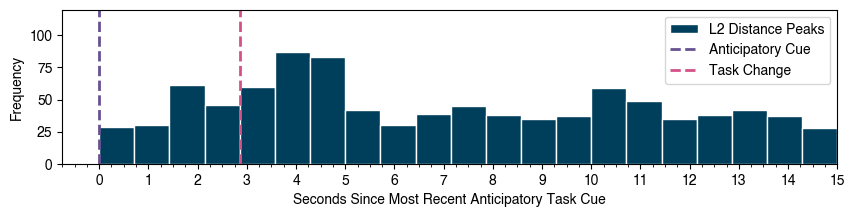

'\nTODO: need to verify the actual offset...\n    Write out equations\n    Note the importance of considering hte actual task change rather than the anticipation for this.\n    Write out the 15s thing in the methods. AND the TR = 0.72...\n    \n    NOTE - it is prudent to say that it takes around 2s for fMRI to start to capture changes.\n    Can just write about IRF in conclusion/discussion, etc.\n\nTODO: add border around this for pub purposes. Say histogram in figure label\n\nThe issue with the current method - in thoery each frame should be displayed to the pt for 1 TR, which means I SHOULD go by that as my reference. \n'

In [328]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.hist(peaks, color=cmap[0], bins=21, align='mid', edgecolor='white', linewidth=1, label='L2 Distance Peaks')
ax.set_xlim(-1, 20)
ax.set_ylim(0, 120)

ax.set_xticks(np.linspace(0, 20, 16), np.arange(16))
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.axvline(0, c=cmap[2], linestyle='--', linewidth=2, label='Anticipatory Cue')
# ax.axvline((3/TR)*20/21, c=cmap[4], linestyle='--', linewidth=2, label='Task Change')
ax.axvline((4)*20/21, c=cmap[4], linestyle='--', linewidth=2, label='Task Change')

ax.set_xlabel('Seconds Since Most Recent Anticipatory Task Cue')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')

fig.savefig('Figure 2', dpi=300, bbox_inches='tight')
plt.show()

'''
TODO: need to verify the actual offset...
    Write out equations
    Note the importance of considering hte actual task change rather than the anticipation for this.
    Write out the 15s thing in the methods. AND the TR = 0.72...
    
    NOTE - it is prudent to say that it takes around 2s for fMRI to start to capture changes.
    Can just write about IRF in conclusion/discussion, etc.

TODO: add border around this for pub purposes. Say histogram in figure label

The issue with the current method - in thoery each frame should be displayed to the pt for 1 TR, which means I SHOULD go by that as my reference. 
'''

In [329]:
'''
Chi-squared to get p-value to use in publication.
'''
print(chisquare(peaks))

Power_divergenceResult(statistic=np.float64(3371.879254183983), pvalue=np.float64(9.909688770459927e-268))


In [330]:
'''
Note - maybe create a table of the subjects I used, gender, other info I have?
'''

'''
Validating the anticipatory task cue -> task change change.

132744.0
'''

# import pandas as pd
# 
# testy = pd.read_csv('/Users/spencerbrown/PycharmProjects/Neuro/Data/100610/100610_3T_MOTOR/MNINonLinear/Results/tfMRI_MOTOR_RL/MOTOR_run1_TAB.txt', sep='\t')
# 
# testy

'\nValidating the anticipatory task cue -> task change change.\n\n132744.0\n'

In [ ]:
'''
Adjustment - moving transitions.
Need to:
    Add 0.50 to standard time point...
    Subtract 0.50 from transtioin
    Cues now line up directly wtih the transition...

Given it starts at 0.5, and I need 2*std = 30 offset on either side.
    I must start at 31 - which goes from 30.5 <-> 31.5, each with 30 minimum.
'''

'''
Assessing cue offset in original expeirment:
First cue: 8.036 s
First task: 11.008 s

Second cue: 23.163 s
Second task: 26.136 s
'''

# a = 8.036
# b = 11.008
# print((b - a), (b - a) / TR)
# 
# a = 23.163
# b = 26.136
# print((b - a), (b - a) / TR)

# cues_truth = np.array([8.030, 23.163, 53.298, 68.412, 83.539, 113.66, 128.787, 143.914, 159.041, 174.168])
# print((cues_truth/TR + 4) * TR) # Underextimates by a constant 0.100s, is fine?
# print(cues_truth+3) #Might as well do this... given it doesn't really matter if it's exact? This notably does demosntrate it better...


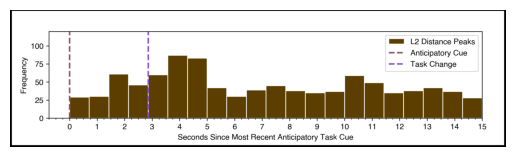

In [331]:
''' Ammended figure with border: '''
import cv2

fig = cv2.imread('Figure 2.png')

pad_R = 75
pad_U = 90
pad_L = 25

fig = np.concatenate([fig, 255 * np.ones((fig.shape[0], pad_R, 3))], axis=1)
fig = np.concatenate([255 * np.ones((fig.shape[0], pad_L, 3)), fig], axis=1)
fig = np.concatenate([255 * np.ones((pad_U, fig.shape[1], 3)), fig], axis=0)

fig[:10, :, :] = 0
fig[:, :10, :] = 0
fig[-10:, :, :] = 0
fig[:, -10:, :] = 0

fig = fig.astype(np.uint8)
cv2.imwrite('Figure 2_ammended.png', fig)

plt.imshow(fig)
plt.axis('off')
plt.show()

In [ ]:
frames